In [ ]:
! nvidia-smi

In [ ]:
! if [ -d HSE.Deep_Unsupervised_Learning ]; then rm -Rf HSE.Deep_Unsupervised_Learning; fi
! git clone https://github.com/SpirinEgor/HSE.Deep_Unsupervised_Learning.git
%cd HSE.Deep_Unsupervised_Learning
! git checkout hw11

In [ ]:
! pip install -q -r requirements.txt

In [1]:
%cd ../..

/Users/Egor.Spirin/HSE/HSE.Deep_Unsupervised_Learning


In [2]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

from utils.hw11_utils import *
from contrastive.byol import BYOL

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams["axes.labelsize"] = 25.0
plt.rcParams["xtick.labelsize"] = 20.0
plt.rcParams["ytick.labelsize"] = 20.0
plt.rcParams["legend.fontsize"] = 18.0

plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [10]:
class MNISTDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx][0]

def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations,) numpy array losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    train_dataset = MNISTDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    latent_dim = 12
    byol = BYOL(latent_dim, device)

    losses = byol.fit(train_dataloader, lr=1e-3, n_epochs=1)
    return losses, byol.encode, latent_dim

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Test classification:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

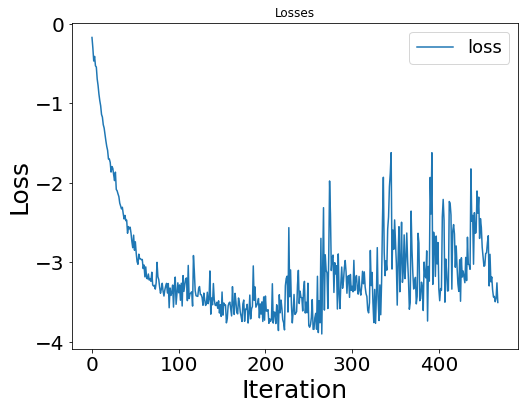

In [14]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)